# PARTE 1

In [56]:
#@title 🔧 Setup: librerie
!pip -q install git+https://github.com/openai/CLIP.git ftfy regex tqdm scikit-learn matplotlib torchvision

import os, math, random, time, numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision.datasets import OxfordIIITPet
import clip
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from sklearn.metrics import pairwise_distances

SEED = 7
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model, preprocess = clip.load("ViT-B/32", device=device) # ViT-L/14, ViT-bigG
model.eval();


  Preparing metadata (setup.py) ... done
Device: cpu


In [4]:
#@title 🐶 Carica dataset
root = "./data"
ds_test = OxfordIIITPet(root=root, split="test", target_types="category",
                        download=True, transform=preprocess)

classes = ds_test.classes  # 37 classi (cani + gatti)
print(f"Classi: {len(classes)} esempi test: {len(ds_test)}")

# Per velocità puoi sotto-campionare (es. 1200)
MAX_SAMPLES = 1600  # metti None per usare tutto
idx = list(range(len(ds_test)))
if MAX_SAMPLES is not None and MAX_SAMPLES < len(idx):
    idx = random.sample(idx, MAX_SAMPLES)
ds_sub = Subset(ds_test, idx)

BATCH = 64
loader = DataLoader(ds_sub, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)


100%|██████████| 792M/792M [00:19<00:00, 40.4MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 15.9MB/s]


Classi: 37 esempi test: 3669


In [40]:
classes

['Abyssinian',
 'American Bulldog',
 'American Pit Bull Terrier',
 'Basset Hound',
 'Beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'Boxer',
 'British Shorthair',
 'Chihuahua',
 'Egyptian Mau',
 'English Cocker Spaniel',
 'English Setter',
 'German Shorthaired',
 'Great Pyrenees',
 'Havanese',
 'Japanese Chin',
 'Keeshond',
 'Leonberger',
 'Maine Coon',
 'Miniature Pinscher',
 'Newfoundland',
 'Persian',
 'Pomeranian',
 'Pug',
 'Ragdoll',
 'Russian Blue',
 'Saint Bernard',
 'Samoyed',
 'Scottish Terrier',
 'Shiba Inu',
 'Siamese',
 'Sphynx',
 'Staffordshire Bull Terrier',
 'Wheaten Terrier',
 'Yorkshire Terrier']

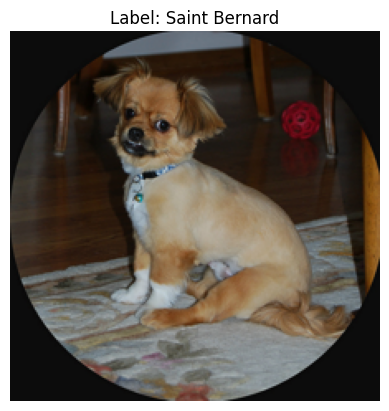

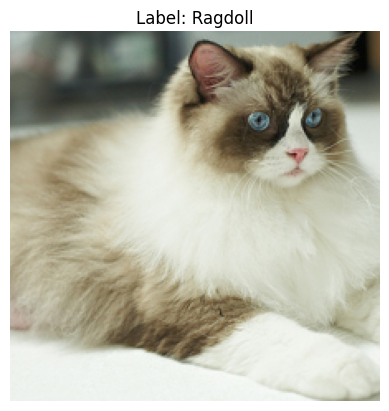

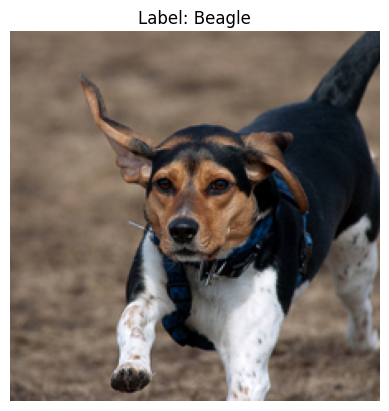

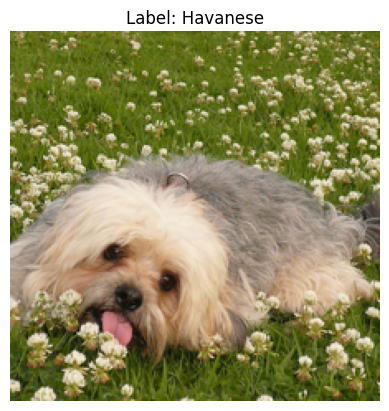

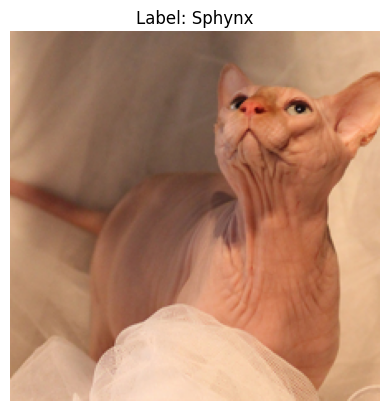

In [42]:
def display_image_from_tensor(image_tensor, title=None):
    """
    Denormalizes and displays an image tensor.

    Args:
        image_tensor (torch.Tensor): The image tensor (C, H, W).
    """
    # Define denormalization (assuming ImageNet normalization)
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).to(image_tensor.device)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).to(image_tensor.device)
    denormalize = torchvision.transforms.Normalize((-mean / std), (1.0 / std))

    # Denormalize the image
    denormalized_image = denormalize(image_tensor)

    # CLIP preprocess outputs a C, H, W tensor. Matplotlib expects H, W, C for color images.
    # Permute the dimensions for plotting
    img_for_display = denormalized_image.permute(1, 2, 0)

    # Clip values to be within the valid range [0, 1] after denormalization and permutation
    img_for_display = torch.clamp(img_for_display, 0, 1)

    # Convert the tensor image to a PIL Image for displaying
    # Ensure the tensor is on CPU and is a numpy array before converting to PIL
    img_pil = F_tv.to_pil_image(img_for_display.cpu().numpy())

    # Display the image
    plt.imshow(img_pil)
    plt.axis('off') # Hide axes
    if title is not None:
      plt.title(f"Label: {title}")
    plt.show()


n_imgs_to_show = 5
for i in random.sample(range(len(ds_sub)), n_imgs_to_show):
    specific_image, specific_label = ds_sub[i]
    display_image_from_tensor(specific_image,classes[specific_label])

In [5]:
#@title ⚙️ Utility numeriche
def l2norm(x, axis=-1, eps=1e-12):
    n = np.linalg.norm(x, axis=axis, keepdims=True)
    return x / (n + eps)

def accuracy_topk(logits, targets, ks=(1,5)):
    # logits: [N, C], targets: [N]
    pred = torch.topk(logits, k=max(ks), dim=1).indices  # [N, maxk]
    res = []
    for k in ks:
        correct = (pred[:, :k] == targets.view(-1,1)).any(dim=1).float().mean().item()
        res.append(correct)
    return res

def pca_dims(X, thresholds=(0.90, 0.95)):
    p = PCA().fit(X)
    c = np.cumsum(p.explained_variance_ratio_) # Percentage of variance explained by each of the selected components.
    out = {}
    for t in thresholds:
        out[f"dim_{int(t*100)}"] = int(np.searchsorted(c, t) + 1)
    return out, p

def rsa_correlation(I, T):
    # I: image feats [Ni, D] (unit norm), T: text feats [Nt, D] (unit norm)
    S = I @ T.T
    I_sim = I @ I.T
    S_z = (S - S.mean(axis=1, keepdims=True)) / (S.std(axis=1, keepdims=True) + 1e-8)
    I_text_struct = np.corrcoef(S_z)  # Ni x Ni
    iu = np.triu_indices_from(I_sim, k=1)
    return spearmanr(I_sim[iu], I_text_struct[iu]).correlation, S

def effective_rank(energy):
    # energy: singolar values energy fractions (sum=1)
    return math.exp(-np.sum(energy * np.log(energy + 1e-12)))


In [6]:
#@title 🖼️ Embedding immagini (cache)
all_image_feats = []
all_targets = []

with torch.no_grad():
    for imgs, labels in loader:
        imgs = imgs.to(device)
        f = model.encode_image(imgs)
        f = f / f.norm(dim=-1, keepdim=True)
        all_image_feats.append(f.cpu())
        all_targets.append(labels)

all_image_feats = torch.cat(all_image_feats, dim=0).numpy()  # [N, D]
all_targets = torch.cat(all_targets, dim=0)                   # [N]
print("image_feats:", all_image_feats.shape, "targets:", all_targets.shape)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


image_feats: (1600, 512) targets: torch.Size([1600])


In [7]:
#@title ✍️ Prompt set
def clean_label(lbl):
    # Oxford-IIIT ha nomi con lettere maiuscole; per CLIP preferisco spazi e minuscole
    return lbl.replace("_", " ").replace("-", " ").strip()

# (A) Baseline: solo il nome classe
templates_baseline = ["{}"]

# (B) Prompt engineering (singolo contesto)
templates_engineered = [
    "a photo of a {}.",
]

# (C) Ensemble di contesti (10-20 bastano per toy; puoi arrivare a 80)
templates_ensemble = [
    "a photo of a {}.",
    "an image of a {}.",
    "a bright photo of a {}.",
    "a low-resolution photo of a {}.",
    "a cropped photo of a {}.",
    "a close-up photo of a {}.",
    "a studio photo of a {}.",
    "a photo of a {}, a type of pet.",
    # specifico per cani/gatti (alcune classi sono gatti)
    "a photo of a {} dog.",
    "a portrait of a {} breed.",
    "a cat of breed {}.",
    "a picture of a {} cat."
]


In [8]:
#@title 🧠 Zero-shot classifier (embedding medio per classe)
@torch.no_grad()
def zeroshot_weights(labels, templates, model, device="cuda"):
    zs = []
    for lbl in labels:
        name = clean_label(lbl)
        texts = [t.format(name) for t in templates]
        tok = clip.tokenize(texts, truncate=True).to(device)
        txt = model.encode_text(tok)
        txt = txt / txt.norm(dim=-1, keepdim=True)
        w = txt.mean(dim=0)
        w = w / w.norm()
        zs.append(w)
    W = torch.stack(zs, dim=1)  # [D, C]
    return W

labels = classes
W_base = zeroshot_weights(labels, templates_baseline, model, device)
W_eng  = zeroshot_weights(labels, templates_engineered, model, device)
W_ens  = zeroshot_weights(labels, templates_ensemble,  model, device)

W_base.shape, W_eng.shape, W_ens.shape


(torch.Size([512, 37]), torch.Size([512, 37]), torch.Size([512, 37]))

In [43]:
#@title 🧪 Valutazione zero-shot
def eval_zeroshot(image_feats_np, targets, W):
    I = torch.from_numpy(image_feats_np)  # [N, D]
    I = I.to(W.device)
    logits = I @ W  # [N, C]
    acc1, acc5 = accuracy_topk(logits, targets.to(W.device), ks=(1,5))
    return acc1, acc5

for name, W in [("baseline", W_base), ("engineered", W_eng), ("ensemble", W_ens)]:
    acc1, acc5 = eval_zeroshot(all_image_feats, all_targets, W)
    print(f"{name:>10} | top1={acc1*100:.2f}%  top5={acc5*100:.2f}% ")


  baseline | top1=80.31%  top5=97.12% 
engineered | top1=84.81%  top5=97.62% 
  ensemble | top1=86.69%  top5=97.81% 


In [65]:
#@title 📏 Funzioni utility
def scatter_stats(X, name="X"):
    # covarianza
    cov = np.cov(X, rowvar=False)
    # log-det (stabile), trace
    sign, logdet = np.linalg.slogdet(cov + 1e-6*np.eye(cov.shape[0]))
    trace = np.trace(cov)
    # PCA dims per 90% e 95% varianza
    pca = PCA().fit(X)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d90 = int(np.searchsorted(cumsum, 0.90) + 1)
    d95 = int(np.searchsorted(cumsum, 0.95) + 1)

    return {
        "trace": trace,
        "logdet": logdet,
        "dim90": d90,
        "dim95": d95,
        "pca_obj": pca,
    }

img_stats = scatter_stats(all_image_feats, "images")

txt_stats = scatter_stats(W_ens, "text")
print("BASELINE")
for k, v in [("TRACE (var totale)", (img_stats["trace"], txt_stats["trace"])),
             ("LOGDET (volume)", (img_stats["logdet"], txt_stats["logdet"]))]:
    print(f"{k:>18}:  IMMAGINI={v[0]}  |  TESTO={v[1]}")



BASELINE
TRACE (var totale):  IMMAGINI=0.2826993611249643  |  TESTO=0.07228115959449352
   LOGDET (volume):  IMMAGINI=-4775.299915006839  |  TESTO=-281.6723497388229


In [73]:
#@title 📊 Dispersione e dimensionalità (immagini vs testi)

# Testo: scegliamo lo spazio **delle classi** (prototipi medi) per coerenza con la task
T_base = W_base.T.cpu().numpy()
T_eng  = W_eng.T.cpu().numpy()
T_ens  = W_ens.T.cpu().numpy()

I = all_image_feats  # già unit-norm

# PCA immagini
dims_img, p_img = pca_dims(I, thresholds=(0.90, 0.95))
dims_txt_base, _ = pca_dims(T_base)
dims_txt_eng,  _ = pca_dims(T_eng)
dims_txt_ens,  _ = pca_dims(T_ens)

print("PCA dims @90/95% var:")
print("Immagini:", dims_img, "     |\n Testo baseline:", dims_txt_base, "|\n engineered:    ", dims_txt_eng, "|\n ensemble:      ", dims_txt_ens)

PCA dims @90/95% var:
Immagini: {'dim_90': 125, 'dim_95': 195}      |
 Testo baseline: {'dim_90': 22, 'dim_95': 27} |
 engineered:     {'dim_90': 21, 'dim_95': 26} |
 ensemble:       {'dim_90': 20, 'dim_95': 25}


In [74]:
#@title 🔗 Costruzione S con tutti i prompt dell'ensemble
@torch.no_grad()
def all_text_embeddings(labels, templates, model, device="cuda"):
    embs = []
    for lbl in labels:
        name = clean_label(lbl)
        texts = [t.format(name) for t in templates]
        tok = clip.tokenize(texts, truncate=True).to(device)
        txt = model.encode_text(tok)
        txt = txt / txt.norm(dim=-1, keepdim=True)
        embs.append(txt.cpu().numpy())
    return np.vstack(embs)  # [C*P, D]


T_all_baseline = all_text_embeddings(labels, templates_baseline, model, device)
print("T_all_baseline:", T_all_baseline.shape)  # (num_class * num_templates, D)

# RSA: struttura immagini vs indotta dal testo (baseline)
rsa_img, S = rsa_correlation(I=I, T=T_all_baseline)
print(f"RSA (immagini native vs indotte dal testo): {rsa_img:.3f}")

T_all_engineered = all_text_embeddings(labels, templates_engineered, model, device)
print("T_all_engineered:", T_all_engineered.shape)  # (num_class * num_templates, D)

# RSA: struttura immagini vs indotta dal testo (engineered)
rsa_img, S = rsa_correlation(I=I, T=T_all_engineered)
print(f"RSA (immagini native vs indotte dal testo): {rsa_img:.3f}")

T_all = all_text_embeddings(labels, templates_ensemble, model, device)
print("T_all:", T_all.shape)  # (num_class * num_templates, D)

# RSA: struttura immagini vs indotta dal testo (ensemble)
rsa_img, S = rsa_correlation(I=I, T=T_all)
print(f"RSA (immagini native vs indotte dal testo): {rsa_img:.3f}")


# SVD(S)
U, s, VT = np.linalg.svd(I @ T_all.T, full_matrices=False)
energy = (s**2) / (s**2).sum()
cum = np.cumsum(energy)
k90 = int(np.searchsorted(cum, 0.90) + 1)
k95 = int(np.searchsorted(cum, 0.95) + 1)
erank = effective_rank(energy)
print(f"\nSVD(S): k90={k90}, k95={k95}, effective-rank≈{erank:.2f}")


T_all_baseline: (37, 512)
RSA (immagini native vs indotte dal testo): 0.591
T_all_engineered: (37, 512)
RSA (immagini native vs indotte dal testo): 0.582
T_all: (444, 512)
RSA (immagini native vs indotte dal testo): 0.582

SVD(S): k90=1, k95=1, effective-rank≈1.31


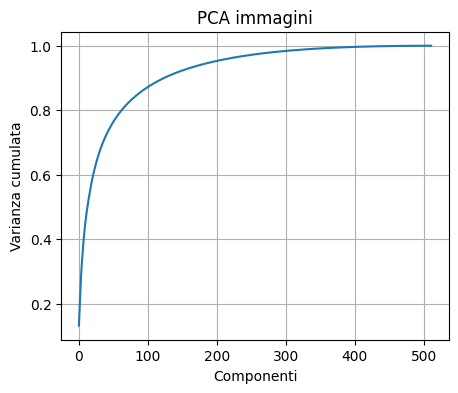

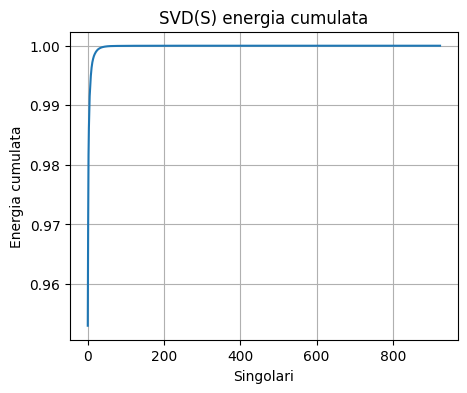

In [46]:
#@title 📈 Plot
plt.figure(figsize=(5,4))
plt.plot(np.cumsum(p_img.explained_variance_ratio_))
plt.xlabel("Componenti"); plt.ylabel("Varianza cumulata"); plt.title("PCA immagini")
plt.grid(True); plt.show()

plt.figure(figsize=(5,4))
plt.plot(np.cumsum(energy))
plt.xlabel("Singolari"); plt.ylabel("Energia cumulata"); plt.title("SVD(S) energia cumulata")
plt.grid(True); plt.show()


In [47]:
#@title 🧾 Report finale
def eval_and_report():
    rows = []
    for name, W in [("baseline", W_base), ("engineered", W_eng), ("ensemble", W_ens)]:
        acc1, acc5 = eval_zeroshot(all_image_feats, all_targets, W)
        rows.append((name, acc1, acc5))
    return rows

rows = eval_and_report()
print("\n== Zero-shot accuracy ==")
for name, a1, a5 in rows:
    print(f"{name:>10}  top1={a1*100:.2f}%  top5={a5*100:.2f}%")

print("\n== PCA dims @90/95% (immagini vs testo) ==")
print("PCA (immagini vs testo): quante componenti servono a spiegare la variabilità.")
print("Immagini:", dims_img)
print("Testo baseline:", dims_txt_base, "| engineered:", dims_txt_eng, "| ensemble:", dims_txt_ens)


print(f"\nRSA(img): correlazione tra 'come sono simili le immagini tra loro' nativamente vs 'come appaiono simili se guardo le risposte a tanti prompt'.")
print(f"RSA(img native vs text-induced using ALL prompts): {rsa_img:.3f}")
print(f"SVD(S): k90={k90}, k95={k95}, effective-rank≈{erank:.2f}")



== Zero-shot accuracy ==
  baseline  top1=80.31%  top5=97.12%
engineered  top1=84.81%  top5=97.62%
  ensemble  top1=86.69%  top5=97.81%

== PCA dims @90/95% (immagini vs testo) ==
PCA (immagini vs testo): quante componenti servono a spiegare la variabilità.
Immagini: {'dim_90': 125, 'dim_95': 195}
Testo baseline: {'dim_90': 22, 'dim_95': 27} | engineered: {'dim_90': 21, 'dim_95': 26} | ensemble: {'dim_90': 20, 'dim_95': 25}

RSA(img): correlazione tra 'come sono simili le immagini tra loro' nativamente vs 'come appaiono simili se guardo le risposte a tanti prompt'.
RSA(img native vs text-induced using ALL prompts): 0.582
SVD(S): k90=1, k95=1, effective-rank≈1.33


In [14]:
#@title 🧪 Ablation semplice: gruppi di template
groups = {
    "generic": [
        "a photo of a {}.",
        "an image of a {}.",
        "a picture of a {}.",
        "a photo of the {}.",
    ],
    "quality": [
        "a bright photo of a {}.",
        "a low-resolution photo of a {}.",
        "a cropped photo of a {}.",
        "a close-up photo of a {}.",
        "a studio photo of a {}.",
    ],
    "domain_pet": [
        "a photo of a {}, a type of pet.",
        "a photo of a {} dog.",
        "a portrait of a {} breed.",
        "a cat of breed {}.",
        "a picture of a {} cat."
    ]
}

ablation = {}
for gname, gtemps in groups.items():
    Wg = zeroshot_weights(labels, gtemps, model, device)
    acc1, acc5 = eval_zeroshot(all_image_feats, all_targets, Wg)
    ablation[gname] = (acc1, acc5)

print("Ablation (top1/top5):")
for k,(a1,a5) in ablation.items():
    print(f"{k:>10}  {a1*100:.2f}% / {a5*100:.2f}%")


Ablation (top1/top5):
   generic  84.19% / 97.69%
   quality  85.19% / 97.62%
domain_pet  89.31% / 99.69%


# PARTE 2
Progetta assi semantici ortogonali (pochi ma “forti”)


In [15]:
#@title ➕ Template ortogonali (scene/framing/action/light/view/count)
orthogonal_templates = [
    # scene
    "an indoor photo of a {}.",
    "an outdoor photo of a {}.",
    # framing
    "a wide shot of a {}.",
    "a close-up photo of a {}.",
    # action
    "a {} running.",
    "a {} sleeping.",
    "a {} jumping.",
    # lighting
    "a {} at night.",
    "a {} in daylight.",
    # viewpoint
    "a side view of a {}.",
    "a front view of a {}.",
    # count
    "a single {}.",
    "two {}s together."
]

# Non modifichiamo templates_ensemble: costruiamo un "super-ensemble" separato
templates_super_ensemble = templates_ensemble + orthogonal_templates
len(templates_super_ensemble)


25

In [16]:
#@title 🧠 Classifier zero-shot con super-ensemble (senza toccare W_ens)
@torch.no_grad()
def zeroshot_weights_safe(labels, templates, model, device="cuda"):
    # identica a zeroshot_weights, ma non sovrascrive nulla
    zs = []
    for lbl in labels:
        name = clean_label(lbl)
        texts = [t.format(name) for t in templates]
        tok = clip.tokenize(texts, truncate=True).to(device)
        txt = model.encode_text(tok)
        txt = txt / txt.norm(dim=-1, keepdim=True)
        w = txt.mean(dim=0)
        w = w / w.norm()
        zs.append(w)
    return torch.stack(zs, dim=1)  # [D, C]

W_super = zeroshot_weights_safe(classes, templates_super_ensemble, model, device)

acc1_super, acc5_super = (lambda I, y, W: (
    accuracy_topk((torch.from_numpy(I).to(W.device) @ W), y.to(W.device), ks=(1,5))
))(all_image_feats, all_targets, W_super)

print(f"super-ensemble | top1={acc1_super*100:.2f}%  top5={acc5_super*100:.2f}%")


super-ensemble | top1=86.06%  top5=97.75%


In [17]:
#@title 🔗 Costruisci S con T_all_super e calcola RSA + SVD
@torch.no_grad()
def all_text_embeddings_safe(labels, templates, model, device="cuda"):
    embs = []
    for lbl in labels:
        name = clean_label(lbl)
        texts = [t.format(name) for t in templates]
        tok = clip.tokenize(texts, truncate=True).to(device)
        txt = model.encode_text(tok)
        txt = txt / txt.norm(dim=-1, keepdim=True)
        embs.append(txt.cpu().numpy())
    return np.vstack(embs)  # [C*P, D]

# I: immagini (unit-norm), T_all_super: tutti i prompt (no media)
I_np = all_image_feats  # già unit-norm dal tuo codice precedente
T_all_super = all_text_embeddings_safe(classes, templates_super_ensemble, model, device)
print("T_all_super:", T_all_super.shape)

# RSA(img native vs text-induced)
def rsa_img_native_vs_text_induced(I, T):
    S = I @ T.T
    I_sim = I @ I.T
    S_z = (S - S.mean(axis=1, keepdims=True)) / (S.std(axis=1, keepdims=True) + 1e-8)
    I_text_struct = np.corrcoef(S_z)  # Ni x Ni
    iu = np.triu_indices_from(I_sim, k=1)
    from scipy.stats import spearmanr
    return spearmanr(I_sim[iu], I_text_struct[iu]).correlation, S

rsa_img_super, S_super = rsa_img_native_vs_text_induced(I_np, T_all_super)
print(f"RSA(img native vs text-induced) super-ensemble: {rsa_img_super:.3f}")

# SVD(S) e rank efficace
U, s, VT = np.linalg.svd(S_super, full_matrices=False)
energy = (s**2) / (s**2).sum()
cum = np.cumsum(energy)
k90_super = int(np.searchsorted(cum, 0.90) + 1)
k95_super = int(np.searchsorted(cum, 0.95) + 1)
effective_rank_super = float(np.exp(-np.sum(energy * np.log(energy + 1e-12))))
print(f"SVD(S) super-ensemble: k90={k90_super}, k95={k95_super}, effective-rank≈{effective_rank_super:.2f}")


T_all_super: (925, 512)
RSA(img native vs text-induced) super-ensemble: 0.605
SVD(S) super-ensemble: k90=1, k95=1, effective-rank≈1.33


# PARTE 3

Singular values: 925  |  k90=1, k95=1, effective-rank≈1.33



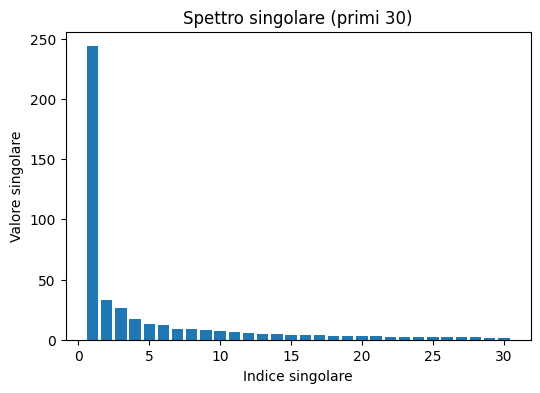

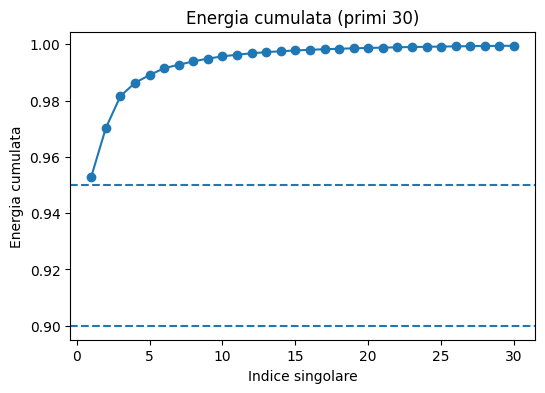

In [51]:
#@title 🔁 S, SVD e spettro (bar + cumulata)
import numpy as np
import matplotlib.pyplot as plt


# SVD
U_svd, s_svd, VT_svd = np.linalg.svd(S_super, full_matrices=False)
energy = (s_svd**2) / (s_svd**2).sum()
cum = np.cumsum(energy)

def effective_rank_from_energy(energy):
    return float(np.exp(-np.sum(energy * np.log(energy + 1e-12))))

erank = effective_rank_from_energy(energy)
k90 = int(np.searchsorted(cum, 0.90) + 1)
k95 = int(np.searchsorted(cum, 0.95) + 1)

print(f"Singular values: {len(s_svd)}  |  k90={k90}, k95={k95}, effective-rank≈{erank:.2f}\n")

# Plot: barre dei primi 30 singolari + cumulata
KSHOW = min(30, len(s_svd))

plt.figure(figsize=(6,4))
plt.bar(np.arange(1, KSHOW+1), s_svd[:KSHOW])
plt.xlabel("Indice singolare"); plt.ylabel("Valore singolare")
plt.title("Spettro singolare (primi 30)")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, KSHOW+1), cum[:KSHOW], marker="o")
plt.axhline(0.90, ls="--"); plt.axhline(0.95, ls="--")
plt.xlabel("Indice singolare"); plt.ylabel("Energia cumulata")
plt.title("Energia cumulata (primi 30)")
plt.show()


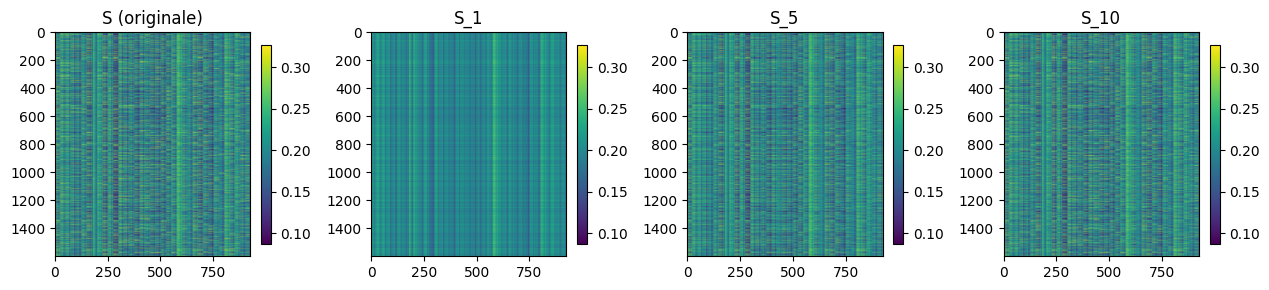

In [52]:
#@title 🔎 Ricostruzioni S_k e heatmap
import matplotlib.pyplot as plt

def reconstruct_rank_k(U, s, VT, k):
    Uk = U[:, :k]
    sk = s[:k]
    VTk = VT[:k, :]
    return Uk @ (np.diag(sk) @ VTk)

def show_heatmaps(S, U, s, VT, ks=(1,5,10), vmax=None):
    if vmax is None:
        vmax = np.percentile(S, 99)  # evita outlier
    vmin = np.percentile(S, 1)
    ncol = len(ks) + 1
    plt.figure(figsize=(3.2*ncol, 3))
    plt.subplot(1, ncol, 1)
    plt.imshow(S, aspect='auto', vmin=vmin, vmax=vmax)
    plt.title("S (originale)"); plt.colorbar(fraction=0.046)
    for j,k in enumerate(ks, start=2):
        Sk = reconstruct_rank_k(U, s, VT, k)
        plt.subplot(1, ncol, j)
        plt.imshow(Sk, aspect='auto', vmin=vmin, vmax=vmax)
        plt.title(f"S_{k}")
        plt.colorbar(fraction=0.046)
    plt.tight_layout(); plt.show()

show_heatmaps(S_super, U_svd, s_svd, VT_svd, ks=(1,5,10))



=== Image idx 331 ===


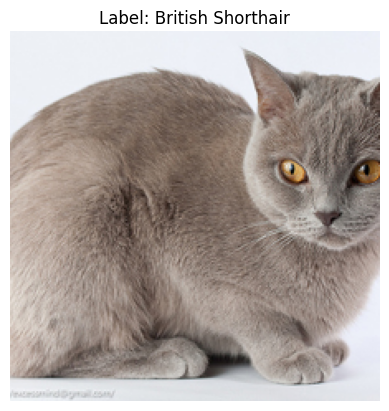


S (full)  | Top-8 prompts:
   0.367  ::  a studio photo of a British Shorthair.
   0.360  ::  a portrait of a British Shorthair breed.
   0.354  ::  a front view of a British Shorthair.
   0.351  ::  an indoor photo of a British Shorthair.
   0.350  ::  a single British Shorthair.
   0.350  ::  an image of a British Shorthair.
   0.349  ::  a picture of a British Shorthair cat.
   0.349  ::  a bright photo of a British Shorthair.

S_1 (rank-1)  | Top-8 prompts:
   0.269  ::  a photo of a Bombay, a type of pet.
   0.257  ::  a photo of a Persian dog.
   0.256  ::  a photo of a Persian, a type of pet.
   0.251  ::  a photo of a Persian.
   0.251  ::  a cropped photo of a Persian.
   0.251  ::  a cat of breed Bombay.
   0.250  ::  an outdoor photo of a Persian.
   0.250  ::  a studio photo of a Persian.

S_5 (rank-5)  | Top-8 prompts:
   0.309  ::  a cat of breed Siamese.
   0.307  ::  an indoor photo of a British Shorthair.
   0.303  ::  a photo of a British Shorthair, a type of pet.
  

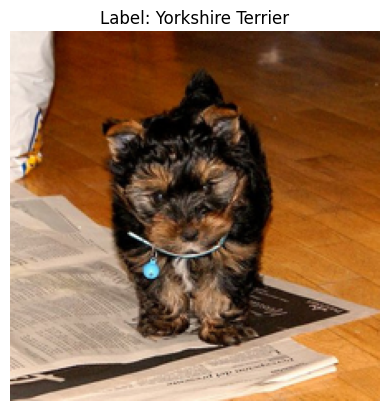


S (full)  | Top-8 prompts:
   0.305  ::  a picture of a Yorkshire Terrier cat.
   0.300  ::  a photo of a Yorkshire Terrier dog.
   0.299  ::  a cat of breed Yorkshire Terrier.
   0.296  ::  a photo of a Yorkshire Terrier.
   0.296  ::  an indoor photo of a Yorkshire Terrier.
   0.294  ::  a photo of a Yorkshire Terrier, a type of pet.
   0.293  ::  a single Yorkshire Terrier.
   0.292  ::  a wide shot of a Yorkshire Terrier.

S_1 (rank-1)  | Top-8 prompts:
   0.266  ::  a photo of a Bombay, a type of pet.
   0.254  ::  a photo of a Persian dog.
   0.253  ::  a photo of a Persian, a type of pet.
   0.248  ::  a photo of a Persian.
   0.248  ::  a cropped photo of a Persian.
   0.248  ::  a cat of breed Bombay.
   0.248  ::  an outdoor photo of a Persian.
   0.247  ::  a studio photo of a Persian.

S_5 (rank-5)  | Top-8 prompts:
   0.282  ::  a cropped photo of a Yorkshire Terrier.
   0.277  ::  a low-resolution photo of a Yorkshire Terrier.
   0.277  ::  a cropped photo of a Scottish 

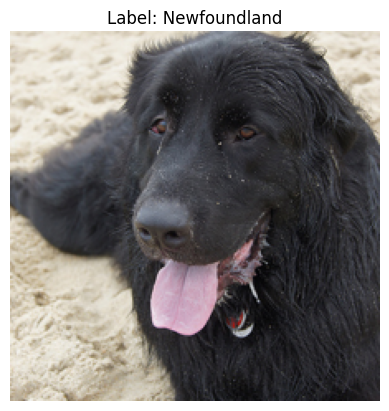


S (full)  | Top-8 prompts:
   0.317  ::  a photo of a Newfoundland dog.
   0.309  ::  a photo of a Newfoundland, a type of pet.
   0.300  ::  a close-up photo of a Newfoundland.
   0.300  ::  a close-up photo of a Newfoundland.
   0.291  ::  a front view of a Newfoundland.
   0.291  ::  a photo of a Newfoundland.
   0.290  ::  a portrait of a Newfoundland breed.
   0.290  ::  a cropped photo of a Newfoundland.

S_1 (rank-1)  | Top-8 prompts:
   0.272  ::  a photo of a Bombay, a type of pet.
   0.260  ::  a photo of a Persian dog.
   0.258  ::  a photo of a Persian, a type of pet.
   0.254  ::  a photo of a Persian.
   0.254  ::  a cropped photo of a Persian.
   0.253  ::  a cat of breed Bombay.
   0.253  ::  an outdoor photo of a Persian.
   0.253  ::  a studio photo of a Persian.

S_5 (rank-5)  | Top-8 prompts:
   0.274  ::  a photo of a English Cocker Spaniel, a type of pet.
   0.272  ::  an outdoor photo of a English Cocker Spaniel.
   0.272  ::  a photo of a English Cocker Spaniel

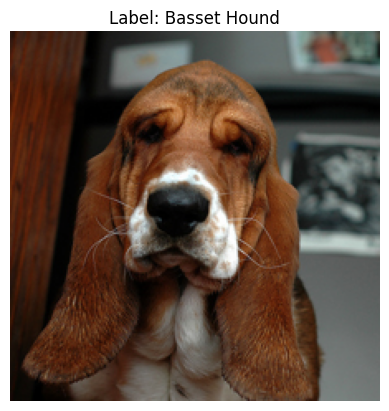


S (full)  | Top-8 prompts:
   0.342  ::  a side view of a Basset Hound.
   0.337  ::  a portrait of a Basset Hound breed.
   0.335  ::  a studio photo of a Basset Hound.
   0.333  ::  a photo of a Basset Hound dog.
   0.331  ::  a picture of a Basset Hound cat.
   0.331  ::  an indoor photo of a Basset Hound.
   0.330  ::  a front view of a Basset Hound.
   0.329  ::  a photo of a Basset Hound.

S_1 (rank-1)  | Top-8 prompts:
   0.250  ::  a photo of a Bombay, a type of pet.
   0.239  ::  a photo of a Persian dog.
   0.237  ::  a photo of a Persian, a type of pet.
   0.233  ::  a photo of a Persian.
   0.233  ::  a cropped photo of a Persian.
   0.233  ::  a cat of breed Bombay.
   0.232  ::  an outdoor photo of a Persian.
   0.232  ::  a studio photo of a Persian.

S_5 (rank-5)  | Top-8 prompts:
   0.274  ::  an image of a American Bulldog.
   0.272  ::  a cropped photo of a Basset Hound.
   0.271  ::  a photo of a American Bulldog, a type of pet.
   0.271  ::  a cropped photo of a A

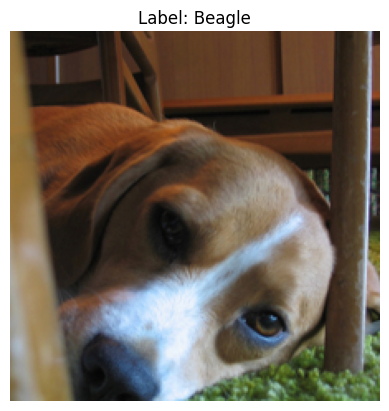


S (full)  | Top-8 prompts:
   0.322  ::  a close-up photo of a Beagle.
   0.322  ::  a close-up photo of a Beagle.
   0.320  ::  an indoor photo of a Beagle.
   0.319  ::  a photo of a Beagle, a type of pet.
   0.315  ::  a cropped photo of a Beagle.
   0.313  ::  a low-resolution photo of a Beagle.
   0.310  ::  a photo of a Beagle dog.
   0.310  ::  an image of a Beagle.

S_1 (rank-1)  | Top-8 prompts:
   0.276  ::  a photo of a Bombay, a type of pet.
   0.264  ::  a photo of a Persian dog.
   0.262  ::  a photo of a Persian, a type of pet.
   0.258  ::  a photo of a Persian.
   0.257  ::  a cropped photo of a Persian.
   0.257  ::  a cat of breed Bombay.
   0.257  ::  an outdoor photo of a Persian.
   0.257  ::  a studio photo of a Persian.

S_5 (rank-5)  | Top-8 prompts:
   0.304  ::  an image of a American Bulldog.
   0.301  ::  a photo of a American Bulldog, a type of pet.
   0.301  ::  a cropped photo of a American Bulldog.
   0.300  ::  a studio photo of a American Bulldog.
  

In [53]:
#@title 🧩 Top-prompt per una immagine: S vs S1 vs S5
import random


def top_prompts_for_image(i, S, T_texts, topk=8):
    row = S[i]
    idx = np.argsort(-row)[:topk]
    return [(int(j), float(row[j]), T_texts[j]) for j in idx]

# Ricrea la lista delle stringhe prompt usate in T_all_super
# Ordine: per ogni classe nell'ordine 'classes', tutti i templates_super_ensemble nell'ordine
T_strings = []
for lbl in classes:
    name = clean_label(lbl)
    T_strings += [t.format(name) for t in templates_super_ensemble]

# S_1 e S_5
S1 = reconstruct_rank_k(U_svd, s_svd, VT_svd, 1)
S5 = reconstruct_rank_k(U_svd, s_svd, VT_svd, 5)


n_imgs_to_show = 5
for i in random.sample(range(S_super.shape[0]), n_imgs_to_show):
    print(f"\n=== Image idx {i} ===")
    specific_image, specific_label = ds_sub[i]
    display_image_from_tensor(specific_image, classes[specific_label])
    for tag, M in [("S (full)", S_super), ("S_1 (rank-1)", S1), ("S_5 (rank-5)", S5)]:
        tops = top_prompts_for_image(i, M, T_strings, topk=8)
        print(f"\n{tag}  | Top-8 prompts:")
        for j,score,txt in tops:
            print(f"  {score:6.3f}  ::  {txt}")


# Take home message 🏡


**Lo spazio visivo è più “grande” della parola.**

- Dimensionalità intrinseca: immagini richiedono molte più componenti per spiegare la varianza


Allineamento asimmetrico tra spazi:

RSA img(native) vs text-induced = XXX → la struttura tra immagini spiegata dai prompt testuali è moderata: il testo cattura solo una parte della geometria visiva.
[TODO FOR EXERCISE ] RSA text(native) vs image-induced = YYY → la struttura tra prompt è ben recuperata guardando come rispondono le immagini: la geometria testuale è più “compressa” e risulta più facile da approssimare via visione.
Accoppiamento dominato da un’unica dimensione condivisa:

SVD(S): k90=1, k95=1, effective-rank≈1.1/1,3 → le corrispondenze immagine↔testo sono guidate quasi interamente da un asse (intuitivamente: “dogness”). Le altre dimensioni visive (razza, posa, contesto, stile) non entrano forte nello spazio condiviso definito dai tuoi prompt.



Interpretazione

1. Parola come compressione, immagine come espansione: i risultati quantificano la tua intuizione—per “cane” la variabilità visiva è molto maggiore della variabilità testuale dei prompt brevi.
2. Il linguaggio che hai usato è troppo “povero” per spiegare la ricchezza visiva: la bassa rank condivisa suggerisce che i prompt, pur numerosi (n=210), collassano su un asse semantico principale.
3. La struttura del testo è più recuperabile dalla visione che viceversa: il che indica che lo spazio dei prompt è più compatto e “rigido”; quello delle immagini ha gradi di libertà che i prompt non toccano.

